In [1]:
!pip install plotly_express

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [94]:
!pip install -U Kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 10.4 MB/s eta 0:00:00


In [2]:
## Importing Basic Packages

import csv
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
pd.set_option('display.max_columns', 50)

# Importing Plotly Packages

import plotly 
import plotly.offline as py
import plotly.graph_objs as go
import plotly_express as px

# Importing sklearn Packages

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel

# Importing scipy Packages
from scipy.sparse.linalg import svds

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Reading in Combined Reviews CSV File

reviews_final = pd.read_csv("/content/drive/MyDrive/Data_Part3/reviews_final.csv")
reviews_final.drop(['Unnamed: 0'], axis=1, inplace = True)
print(reviews_final.shape)
reviews_final.head(3)

(48390, 25)


,user_id,business_id,stars,useful,funny,cool,text,date,year,month,time,word_count,character_count,avg_word_length,count_of_stopwords,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks
0,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1.0,0.0,1.0,"Wow! Yummy, different, delicious. Our favo...",1/4/2015 0:01,2015.0,1.0,0:01:03,48.0,243.0,4.900000,12.0,wow yummy different delicious favorite lamb cu...,0.315152,0.733838,0.000,0.660,0.340,0.9588,4.0,"order, time, give, place, food, eat, sandwich,...","['different', 'favorite', 'different', 'kind',..."
1,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5.0,0.0,0.0,0.0,My boyfriend and I tried this deli for the fir...,8/23/2018 21:39,2018.0,8.0,21:39:38,73.0,393.0,4.397260,25.0,boyfriend tried deli first time today turkey a...,0.138889,0.492593,0.000,0.843,0.157,0.9168,1.0,"food, great, place, service, love, restaurant,...","['boyfriend', 'deli', 'first', 'time', 'today'..."
2,G0DHgkSsDozqUPWtlxVEMw,oBhJuukGRqPVvYBfTkhuZA,4.0,0.0,0.0,0.0,The only reason I didn't give this restaurant ...,3/5/2015 3:37,2015.0,3.0,3:37:54,422.0,2343.0,4.547393,177.0,reason didnt give restaurant 5 star rating one...,0.093537,0.476332,0.053,0.857,0.089,0.9305,3.0,"table, wait, ask, minute, service, server, sea...","['reason', 'give', 'restaurant', 'star', 'rati..."


# **Developing a Super - Score Rating**

To begin constructing our recommendation systems, our initial task is to create a rating score that represents each user's overall restaurant preferences. While our reviews dataset includes the actual star ratings provided by users in their Yelp Reviews, we aim to develop our own Super Score rating. This will involve combining these ratings with additional sentiment scores, such as Textblob's polarity and VADER compound scores.


1.   Text polarity is measured on a scale of -1 to +1, indicating a negative or positive sentiment.
2.   The subjectivity score ranges from 0 to 1, indicating the degree of objectivity or subjectivity present in the text.
3. The compound score is determined by adding up the valence scores of each word in the lexicon, modified according to specific rules, and then standardized to a scale of -1 (extremely negative) to +1 (extremely positive).

Formula: **Super Score** = stars + (polarity x compound)

In [5]:
# Computing Super-Score Rating for Reviews

reviews_final['super_score'] = reviews_final['polarity'] *  reviews_final['compound']
reviews_final['super_score'] = reviews_final['super_score'] + reviews_final['stars']
reviews_final.sample(3)

,user_id,business_id,stars,useful,funny,cool,text,date,year,month,time,word_count,character_count,avg_word_length,count_of_stopwords,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks,super_score
16509,luWJzuScGnLiP4_YeJ32jA,eqNutOMnPqKa9QDAY6KfEw,4.0,0.0,0.0,0.0,Really chill place to eat your weight in delic...,8/28/2019 19:23,2019.0,8.0,19:23:11,51.0,289.0,4.686275,15.0,really chill place eat weight delicious cake c...,0.434524,0.633333,0.032,0.619,0.349,0.9722,1.0,"food, great, place, service, love, restaurant,...","['live', 'girlfriend', 'jasmine', 'tonight', '...",4.422444
47235,Gf7hQ5bEoeKP19AJbAsBKQ,6ewV-e7-39oqYUq3yZuIyw,5.0,1.0,0.0,1.0,"I barely have breakfast in a restaurant, but I...",5/18/2018 5:36,2018.0,5.0,5:36:28,35.0,193.0,4.542857,13.0,barely breakfast restaurant cafe loved friendl...,0.505000,0.560000,0.000,0.622,0.378,0.9676,4.0,"order, time, give, place, food, eat, sandwich,...","['food', 'mostly', 'depend', 'time', 'order', ...",5.488638
45680,2LcC1R65TLmgfj1djSnguw,TunmRrfZb7bt53T6HJi4UQ,4.0,0.0,0.0,0.0,"Great sushi, great atmosphere. While the locat...",6/28/2015 1:07,2015.0,6.0,1:07:55,151.0,841.0,4.519737,63.0,great sushi great atmosphere location isnt big...,0.425654,0.581474,0.000,0.718,0.282,0.9947,1.0,"food, great, place, service, love, restaurant,...","['favorite', 'pizza', 'place', 'great', 'pizza...",4.423398


In [6]:
# Checking whether there are any rows with zero super scores

reviews_final[reviews_final['super_score']==0.0]

,user_id,business_id,stars,useful,funny,cool,text,date,year,month,time,word_count,character_count,avg_word_length,count_of_stopwords,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks,super_score


In [7]:
# Minimum Super Score Rating

reviews_final['super_score'].min()

0.3541599999999999

In [8]:
# Maximum Super Score Rating

reviews_final['super_score'].max()

5.9726

The range of Super Score Ratings is from [0,6].

# **Cold-Start Problem**

Recommender systems face an issue referred to as "user cold-start," which makes it challenging to offer tailored recommendations for users who have not consumed many items, or have not consumed any items at all. This is because there is insufficient information to create a model of their preferences.

In situations where I am a recent user of a food delivery app, or I am new to a city, it will be challenging to receive personalized recommendations because there is insufficient information available about my individual food and restaurant preferences.

In the context of the cold-start problem, it is necessary to provide satisfactory recommendations to users who have not provided any feedback. Since these users have an empty data set, there are no relevant relationships that can be inferred. A possible solution to this issue could involve providing a random initial recommendation, and then continually updating the recommendation based on the feedback received, retraining the model, sorting the predicted ratings, and returning the highest projected recommendation for future recommendations.

A potential method for providing recommendations to a new user is through location-based data. By utilizing a user's current geographic location when they are searching for new restaurants to visit, a location-based recommendation system can be employed to suggest restaurants in close proximity to their location. This approach aims to entice the user to use the app by providing a convenient initial recommendation, after which other recommendation systems can be utilized to recommend additional restaurants based on their preferences.



In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Location-Based Recommendation System**

In [10]:
# Reading in Restaurant Businesses Final CSV File

final_business = pd.read_csv("/content/drive/MyDrive/Data_Part1/business_final.csv")
final_business.drop(['Unnamed: 0'], axis=1, inplace = True)
print(final_business.shape)
final_business.head(3)

(3529, 12)


,business_id,name,city,state,stars,review_count,categories,latitude,longitude,is_open,postal_code,key
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,Philadelphia,PA,4.0,80,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",39.955505,-75.155564,1,19107,MTSW4McQd7CbVtyjqoe9mw
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,Philadelphia,PA,4.0,245,"Sushi Bars, Restaurants, Japanese",39.953949,-75.143226,1,19106,MUTTqe8uqyMdBl186RmNeA
2,ROeacJQwBeh05Rqg7F6TCg,BAP,Philadelphia,PA,4.5,205,"Korean, Restaurants",39.943223,-75.162568,1,19147,ROeacJQwBeh05Rqg7F6TCg


In [11]:
# Filtering for Selected Columns

final_business['business_id'] = final_business['business_id ']
final_business = final_business[['business_id', 'name', 'categories','stars','review_count','latitude','longitude','postal_code']]
final_business.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4.0,80,39.955505,-75.155564,19107
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,"Sushi Bars, Restaurants, Japanese",4.0,245,39.953949,-75.143226,19106
2,ROeacJQwBeh05Rqg7F6TCg,BAP,"Korean, Restaurants",4.5,205,39.943223,-75.162568,19147
3,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,...",3.5,65,39.962582,-75.135657,19123
4,ppFCk9aQkM338Rgwpl2F5A,Wawa,"Restaurants, Automotive, Delis, Gas Stations, ...",3.0,56,39.954573,-75.194894,19104


In [12]:
# Geographical Overview of Restaurants in Philadelphia City

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
figure = px.scatter_mapbox(final_business, lat="latitude", lon="longitude", color="stars", size='review_count',
                   size_max=15, zoom=10, width=1000, height=700)

figure.update_layout(mapbox_style="dark")
figure.show()

# K-Means **Clustering**

According to the visualization presented, certain areas in Philadelphia have a higher concentration of restaurants compared to others. Thus, recommending restaurants that are close to a user's current location, irrespective of their location within the city, would be a logical approach. This would ensure that the user is provided with recommendations that are conveniently located nearby, regardless of their geographical location within the city.

Therefore, an approach to group restaurants together based on their geographical location could be accomplished through the utilization of the **K-Means Clustering Algorithm**. This algorithm is capable of predicting the cluster in which the user is located, and then selecting the top 10 restaurants within that cluster to recommend to the user.

In [13]:
# Putting the Coordinates of Restaurants together into a dataframe

all_coordinates = final_business[['longitude','latitude']]
all_coordinates # Total of 5,471 Locations for 5,471 Unique Restaurants

,longitude,latitude
0,-75.155564,39.955505
1,-75.143226,39.953949
2,-75.162568,39.943223
3,-75.135657,39.962582
4,-75.194894,39.954573
...,...,...
3524,-75.174728,39.925205
3525,-75.157752,39.970720
3526,-75.189916,39.957447
3527,-75.214430,40.032483


In [14]:
# Elbow method to determine the number of K in Kmeans Clustering

distortions = []
K = range(1,15)
for k in K:
    kmeansModel = KMeans(n_clusters=k)
    kmeansModel = kmeansModel.fit(all_coordinates)
    distortions.append(kmeansModel.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

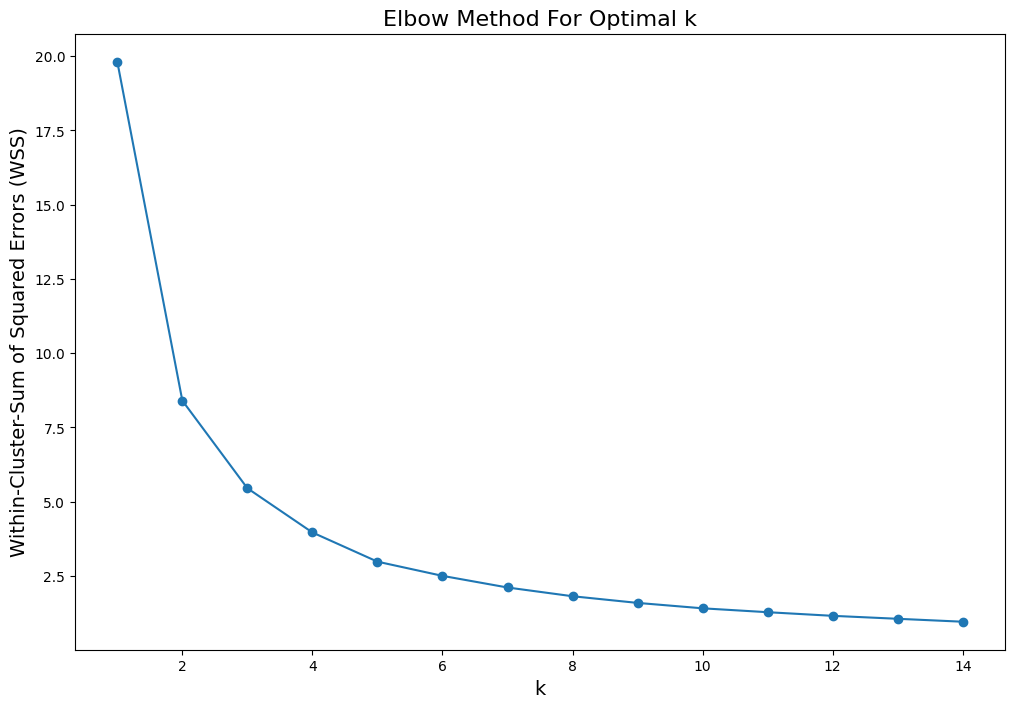

In [15]:
# Elbow Graph for WSS

figure, ax = plt.subplots(figsize=(12, 8))
plt.plot(K, distortions, marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Within-Cluster-Sum of Squared Errors (WSS)', fontsize = 14)
plt.title('Elbow Method For Optimal k', fontsize = 16)
plt.show()


To use the Elbow Method, we need to compute the Within-Cluster-Sum of Squared Errors (WSS) for various values of k, and then select the k value where WSS begins to decrease. This is visible as an elbow in the WSS-versus-k plot. According to the graph shown above, the ideal k value is 4 clusters.

In [16]:
# Silhouette Score Method to to determine the number of K in Kmeans Clustering

sil = []
kmax = 25

# Dissimilarity would not be defined for a single cluster. Minimum number of clusters should be 2

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k).fit(all_coordinates)
  labels = kmeans.labels_
  sil.append(silhouette_score(all_coordinates, labels, metric = 'euclidean'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will chang

In [17]:
# Silhouette Scores

sil

[0.602021265962187,
 0.5525506267467761,
 0.5007937340944677,
 0.49687929743433906,
 0.4704982580601353,
 0.4805422270631111,
 0.4694343039914856,
 0.42378359563866097,
 0.42733886161469375,
 0.43631277629912757,
 0.43179400248104094,
 0.4463246606535945,
 0.4309709985932225,
 0.4234317921755533,
 0.41727030428987183,
 0.429007998441504,
 0.4359043474263885,
 0.44413033918251477,
 0.424706028043183,
 0.422006187857393,
 0.417600981087202,
 0.4196054684453018,
 0.41849524198579025,
 0.42724000785203586]

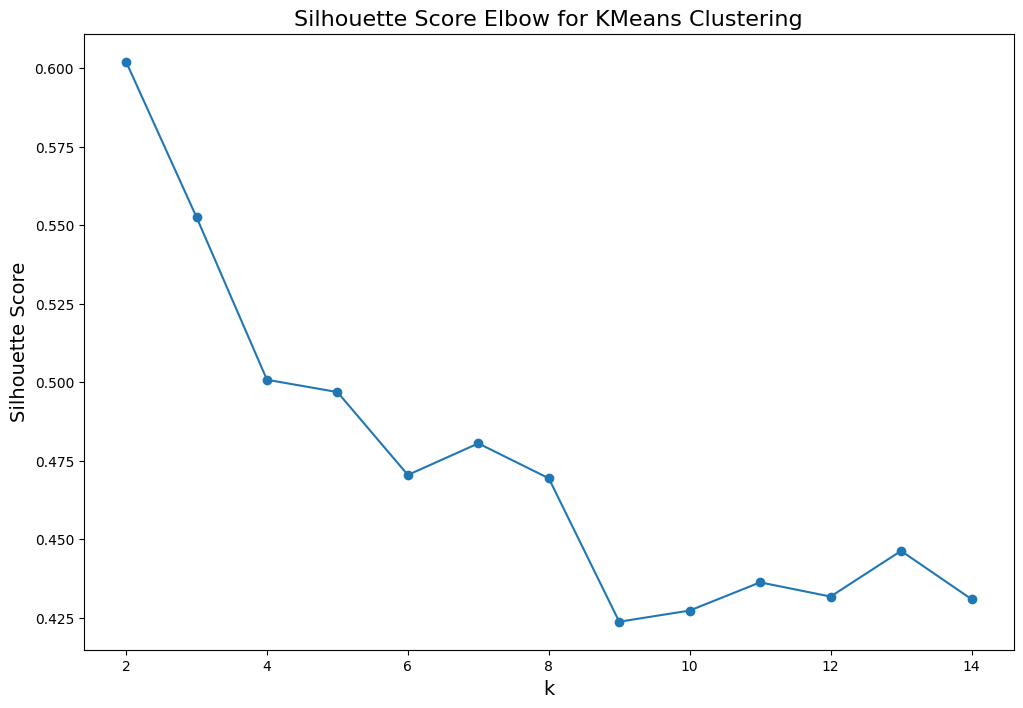

In [18]:
# Elbow Graph for Silhouette Score

figure, ax = plt.subplots(figsize=(12, 8))
plt.plot(K[1:15], sil[:13], marker='o')
plt.xlabel('k', fontsize = 14)
plt.ylabel('Silhouette Score', fontsize = 14)
plt.title('Silhouette Score Elbow for KMeans Clustering', fontsize = 16)
plt.show()

In [19]:
# Setting K = 4

kmeans = KMeans(n_clusters = 4, init = 'k-means++')
kmeans.fit(all_coordinates)
y = kmeans.labels_
print("k = 4", " silhouette_score ", silhouette_score(all_coordinates, y, metric='euclidean'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



k = 4  silhouette_score  0.5007937340944677


In [20]:
final_business['init_cluster'] = kmeans.predict(final_business[['longitude','latitude']])
final_business.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4.0,80,39.955505,-75.155564,19107,2
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,"Sushi Bars, Restaurants, Japanese",4.0,245,39.953949,-75.143226,19106,2
2,ROeacJQwBeh05Rqg7F6TCg,BAP,"Korean, Restaurants",4.5,205,39.943223,-75.162568,19147,2
3,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,...",3.5,65,39.962582,-75.135657,19123,2
4,ppFCk9aQkM338Rgwpl2F5A,Wawa,"Restaurants, Automotive, Delis, Gas Stations, ...",3.0,56,39.954573,-75.194894,19104,0


In [21]:
# Geographical Plot of 4 Clusters

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
figure = px.scatter_mapbox(final_business, lat="latitude", lon="longitude", color="init_cluster", size='review_count', 
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1000, height=700)

figure.update_layout(mapbox_style="dark")
figure.show()

The plot above shows that although there are 4 clusters, the less dense areas have restaurants that are scattered across long distances within the clusters. This might discourage users from visiting the recommended restaurants if they are too far from their location.

Therefore, even though 4 clusters may seem to be the best option, in this scenario, it would be more beneficial to have more clusters that are smaller and spread throughout the city of Philadelphia.

In [23]:
# Let's try k = 10

kmeans = KMeans(n_clusters = 10, init = 'k-means++')
kmeans.fit(all_coordinates)
y = kmeans.labels_
print("k = 10", " silhouette_score ", silhouette_score(all_coordinates, y, metric='euclidean'))

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



k = 10  silhouette_score  0.4290434014887081


In [22]:
final_business['cluster'] = kmeans.predict(final_business[['longitude','latitude']])
final_business.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4.0,80,39.955505,-75.155564,19107,2,2
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,"Sushi Bars, Restaurants, Japanese",4.0,245,39.953949,-75.143226,19106,2,2
2,ROeacJQwBeh05Rqg7F6TCg,BAP,"Korean, Restaurants",4.5,205,39.943223,-75.162568,19147,2,2
3,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,...",3.5,65,39.962582,-75.135657,19123,2,2
4,ppFCk9aQkM338Rgwpl2F5A,Wawa,"Restaurants, Automotive, Delis, Gas Stations, ...",3.0,56,39.954573,-75.194894,19104,0,0


In [24]:
# Geographical Plot of 10 Clusters

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
figure = px.scatter_mapbox(final_business, lat="latitude", lon="longitude", color="cluster", size='review_count', 
                  hover_data= ['name', 'latitude', 'longitude'], zoom=10, width=1000, height=800)

figure.update_layout(mapbox_style="dark")
figure.show()

By creating more clusters, the Location-Based Recommendation System can suggest restaurants to users in Philadelphia that are closer to their current geographical location, given that Philadelphia has a land area of **142.70 square miles**.

In addition to suggesting restaurants in the vicinity of a user, it is crucial that the recommended establishments have the highest possible rating. Restaurants that receive **higher ratings (in stars)** typically offer a** superior dining experience**, which can enhance a user's satisfaction with our recommendation system.

In [25]:
# Sort Restaurants based on Stars(rating) and subsequently by Review_count

top_restaurants_philadelphia = final_business.sort_values(by=['stars', 'review_count'], ascending=False)
top_restaurants_philadelphia.head()

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
1648,TE2IEDNV0RcI6s1wTOP4fg,Tortilleria San Roman,"Convenience Stores, Italian, Specialty Food, M...",5.0,219,39.937636,-75.158082,19147,2,2
2795,Ktg3ahIxk0JIkJwXAqu2ew,Hikari Sushi,"Restaurants, Sushi Bars, Japanese",5.0,155,39.967402,-75.141153,19123,2,2
3316,kT8IlV47kz1rz2lTuNyO1w,Christie's Deli,"Restaurants, Breakfast & Brunch, Delis, Sandwi...",5.0,152,39.963081,-75.169360,19130,2,2
2022,UMHuKs1sO-wq3XqKaejXeA,Miss Rachel's Pantry,"Arts & Crafts, Food, Shopping, Food Delivery S...",5.0,119,39.926515,-75.173776,19145,2,2
1881,gvD09Ev1aOmphtlq07zYEA,El Rancho Viejo,"Restaurants, Mexican",5.0,110,39.936282,-75.152142,19147,2,2


In [26]:
# Creating Location-Based Recommendation Function

def recommendation_locationbased(df, latitude, longitude):
    
    """Predict the cluster for longitude and latitude provided"""
    cluster = kmeans.predict(np.array([longitude,latitude]).reshape(1,-1))[0]
    print("This restaurant belongs to cluster:", cluster)
   
    """Get the best restaurant in this cluster along with the relevant information for a user to make a decision"""
    return df[df['cluster']==cluster].iloc[0:10][['name', 'latitude','longitude','categories','stars', 'review_count','cluster']]


# **Sample Case Studies**

In [27]:
test_coordinates = {
    'user': [1, 2, 3], 
    'latitude' : [39.949, 39.941, 39.958],
    'longitude' : [-75.155, -75.196, -75.175],
}

test_df = pd.DataFrame(test_coordinates)
test_df

,user,latitude,longitude
0,1,39.949,-75.155
1,2,39.941,-75.196
2,3,39.958,-75.175


**Case Study 1:**
Let's consider our initial scenario where a user is present at the coordinates 39.949 and -75.155 and is interested in having a meal but is uncertain about the availability of good restaurants in the vicinity.

In [28]:
user1 = test_df[test_df['user'] == 1]
user1

,user,latitude,longitude
0,1,39.949,-75.155


In [29]:
recommendation_locationbased(top_restaurants_philadelphia, user1.latitude, user1.longitude)

This restaurant belongs to cluster: 0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



,name,latitude,longitude,categories,stars,review_count,cluster
1685,Ferrante's Meats & More,39.977642,-75.266764,"Event Planning & Services, Food, Caterers, San...",5.0,24,0
224,Mike's Hot Dog Cart,39.922381,-75.186929,"Food Stands, Restaurants",5.0,22,0
2890,Fresh Donuts,39.962212,-75.201024,"Donuts, Breakfast & Brunch, Restaurants, Coffe...",5.0,22,0
3383,Alif Brew & Mini Mart,39.949178,-75.213168,"Restaurants, Food, Convenience Stores, Cafes, ...",5.0,19,0
1149,Linda's Cart,39.953042,-75.217928,"Food, Restaurants, Food Stands",5.0,16,0
570,52nd Station Diner,39.959681,-75.224842,"Comfort Food, Diners, Restaurants, Breakfast &...",5.0,15,0
2423,Fudena,39.939628,-75.186640,"African, Food, Food Delivery Services, Restaur...",5.0,15,0
246,Mommy Telly's Famous BBQ,39.956532,-75.189178,"Food, Food Trucks, Barbeque, Restaurants, Fili...",5.0,14,0
1390,The Gables Cafe,39.944194,-75.209709,"Food, Coffee & Tea, Restaurants, Italian, Dess...",5.0,14,0
2827,Rio Brazilan Steak Truck,39.955744,-75.190922,"Food, Event Planning & Services, Barbeque, Cat...",5.0,9,0


In [30]:
# Geographical Plot of Nearby Recommended Restaurants from coordinates 39.949 and -75.155

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
figure = px.scatter_mapbox(recommendation_locationbased(top_restaurants_philadelphia, user1.latitude, user1.longitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1000, height=700, hover_data= ['name', 'latitude', 'longitude', 'categories', 'stars', 'review_count'])
figure.add_scattermapbox(lat=user1["latitude"], lon= user1["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))
figure.update_layout(mapbox_style="dark")

This restaurant belongs to cluster: 0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



**Case Study 2:**

Let's consider our second scenario where the user has recently arrived at the geographical coordinates 39.941 and -75.196 in Philadelphia. The user is feeling tired and wishes to find a restaurant in the area to relax and enjoy a refreshing meal.

In [31]:
user2 = test_df[test_df['user'] == 2]
user2 = test_df[test_df['user'] == 2].reset_index()
user2

,index,user,latitude,longitude
0,1,2,39.941,-75.196


In [32]:
recommendation_locationbased(top_restaurants_philadelphia, user2.latitude, user2.longitude)

This restaurant belongs to cluster: 3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



,name,latitude,longitude,categories,stars,review_count,cluster
1225,New Ridge Brewing,40.034931,-75.217059,"Restaurants, Gastropubs, Breweries, Food",5.0,54,3
132,Alena’s Cafe,40.051374,-75.184941,"Cafes, Restaurants",5.0,29,3
1020,Far East Chinese Cuisine,40.019695,-75.174272,"Cantonese, Chinese, Restaurants",5.0,28,3
1428,Veghada,40.043394,-75.144670,"Food, Restaurants, Vegan, Vegetarian, Specialt...",5.0,27,3
3037,Haggerty Deli,40.029168,-75.225595,"Convenience Stores, Food, Restaurants, Delis",5.0,19,3
2540,Halal Food Truck,40.031943,-75.213393,"Food Trucks, Food, Restaurants, Halal",5.0,14,3
3059,Streetside BBQ,40.072916,-75.169130,"Food, Food Delivery Services, Caterers, Event ...",5.0,14,3
2937,Pauline's Deli,40.040833,-75.157468,"Delis, Restaurants",5.0,11,3
332,Algorithm Restaurants,40.116933,-75.355294,"Food, Food Trucks, Pop-Up Restaurants, Busines...",5.0,10,3
1603,Adelie Coffee House,40.050681,-75.185112,"Restaurants, Food, Coffee & Tea, Cafes, Breakf...",5.0,10,3


In [33]:
# Geographical Plot of Nearby Recommended Restaurants from coordinates 39.941	and -75.196

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
figure = px.scatter_mapbox(recommendation_locationbased(top_restaurants_philadelphia, user2.latitude, user2.longitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1000, height=700, hover_data= ['name', 'latitude', 'longitude', 'categories', 'stars', 'review_count'])
figure.add_scattermapbox(lat=user2["latitude"], lon= user2["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))
figure.update_layout(mapbox_style="dark")

This restaurant belongs to cluster: 3


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



**Case Study 3: **

For our third scenario, the user has recently arrived at coordinates 39.958 and -75.175, and is now seeking to find a nearby restaurant where he can relax and contemplate his visit while also satisfying his hunger.

In [34]:
user3 = test_df[test_df['user'] == 3]
user3 = test_df[test_df['user'] == 3].reset_index()
user3


,index,user,latitude,longitude
0,2,3,39.958,-75.175


In [35]:
recommendation_locationbased(top_restaurants_philadelphia, user3.latitude, user3.longitude)

This restaurant belongs to cluster: 0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



,name,latitude,longitude,categories,stars,review_count,cluster
1685,Ferrante's Meats & More,39.977642,-75.266764,"Event Planning & Services, Food, Caterers, San...",5.0,24,0
224,Mike's Hot Dog Cart,39.922381,-75.186929,"Food Stands, Restaurants",5.0,22,0
2890,Fresh Donuts,39.962212,-75.201024,"Donuts, Breakfast & Brunch, Restaurants, Coffe...",5.0,22,0
3383,Alif Brew & Mini Mart,39.949178,-75.213168,"Restaurants, Food, Convenience Stores, Cafes, ...",5.0,19,0
1149,Linda's Cart,39.953042,-75.217928,"Food, Restaurants, Food Stands",5.0,16,0
570,52nd Station Diner,39.959681,-75.224842,"Comfort Food, Diners, Restaurants, Breakfast &...",5.0,15,0
2423,Fudena,39.939628,-75.186640,"African, Food, Food Delivery Services, Restaur...",5.0,15,0
246,Mommy Telly's Famous BBQ,39.956532,-75.189178,"Food, Food Trucks, Barbeque, Restaurants, Fili...",5.0,14,0
1390,The Gables Cafe,39.944194,-75.209709,"Food, Coffee & Tea, Restaurants, Italian, Dess...",5.0,14,0
2827,Rio Brazilan Steak Truck,39.955744,-75.190922,"Food, Event Planning & Services, Barbeque, Cat...",5.0,9,0


In [36]:
# Geographical Plot of Nearby Recommended Restaurants from coordinates 39.958	-75.175

px.set_mapbox_access_token("pk.eyJ1Ijoic2hha2Fzb20iLCJhIjoiY2plMWg1NGFpMXZ5NjJxbjhlM2ttN3AwbiJ9.RtGYHmreKiyBfHuElgYq_w")
figure = px.scatter_mapbox(recommendation_locationbased(top_restaurants_philadelphia, user3.latitude, user3.longitude), lat="latitude", lon="longitude",  
                   zoom=10, width=1000, height=700, hover_data= ['name', 'latitude', 'longitude', 'categories', 'stars', 'review_count'])
figure.add_scattermapbox(lat=user3["latitude"], lon= user3["longitude"]).update_traces(dict(mode='markers', marker = dict(size = 15)))
figure.update_layout(mapbox_style="dark")

This restaurant belongs to cluster: 0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



# **Collaborative-Filtering Recommendation System**

**Collaborative filtering** is a method that can help identify items that a user might be interested in based on the preferences of similar users.

The approach involves searching through a large population of individuals to identify a smaller group with similar tastes to a particular user. By examining the items that this group has liked, a ranked list of suggestions can be generated for the user.

# **Creating User-Item Matrix**

In [37]:
reviews_final.head(3)

,user_id,business_id,stars,useful,funny,cool,text,date,year,month,time,word_count,character_count,avg_word_length,count_of_stopwords,cleaned_text,polarity,subjectivity,neg,neu,pos,compound,Dominant_Topic,Keywords,Text_Chunks,super_score
0,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1.0,0.0,1.0,"Wow! Yummy, different, delicious. Our favo...",1/4/2015 0:01,2015.0,1.0,0:01:03,48.0,243.0,4.900000,12.0,wow yummy different delicious favorite lamb cu...,0.315152,0.733838,0.000,0.660,0.340,0.9588,4.0,"order, time, give, place, food, eat, sandwich,...","['different', 'favorite', 'different', 'kind',...",5.302167
1,aFa96pz67TwOFu4Weq5Agg,kq5Ghhh14r-eCxlVmlyd8w,5.0,0.0,0.0,0.0,My boyfriend and I tried this deli for the fir...,8/23/2018 21:39,2018.0,8.0,21:39:38,73.0,393.0,4.397260,25.0,boyfriend tried deli first time today turkey a...,0.138889,0.492593,0.000,0.843,0.157,0.9168,1.0,"food, great, place, service, love, restaurant,...","['boyfriend', 'deli', 'first', 'time', 'today'...",5.127333
2,G0DHgkSsDozqUPWtlxVEMw,oBhJuukGRqPVvYBfTkhuZA,4.0,0.0,0.0,0.0,The only reason I didn't give this restaurant ...,3/5/2015 3:37,2015.0,3.0,3:37:54,422.0,2343.0,4.547393,177.0,reason didnt give restaurant 5 star rating one...,0.093537,0.476332,0.053,0.857,0.089,0.9305,3.0,"table, wait, ask, minute, service, server, sea...","['reason', 'give', 'restaurant', 'star', 'rati...",4.087037


In [38]:
final_business.head(3)

,business_id,name,categories,stars,review_count,latitude,longitude,postal_code,init_cluster,cluster
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B...",4.0,80,39.955505,-75.155564,19107,2,2
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,"Sushi Bars, Restaurants, Japanese",4.0,245,39.953949,-75.143226,19106,2,2
2,ROeacJQwBeh05Rqg7F6TCg,BAP,"Korean, Restaurants",4.5,205,39.943223,-75.162568,19147,2,2


In [39]:
# Filtering for Selected Columns

df_final = reviews_final[['business_id', 'user_id', 'super_score', 'Keywords']]
df_final.head(3)


,business_id,user_id,super_score,Keywords
0,kxX2SOes4o-D3ZQBkiMRfA,_7bHUi9Uuf5__HHc_Q8guQ,5.302167,"order, time, give, place, food, eat, sandwich,..."
1,kq5Ghhh14r-eCxlVmlyd8w,aFa96pz67TwOFu4Weq5Agg,5.127333,"food, great, place, service, love, restaurant,..."
2,oBhJuukGRqPVvYBfTkhuZA,G0DHgkSsDozqUPWtlxVEMw,4.087037,"table, wait, ask, minute, service, server, sea..."


In [40]:
philadelphia_restaurant = final_business[['business_id', 'name', 'categories']]
philadelphia_restaurant.head()

,business_id,name,categories
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
1,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,"Sushi Bars, Restaurants, Japanese"
2,ROeacJQwBeh05Rqg7F6TCg,BAP,"Korean, Restaurants"
3,aPNXGTDkf-4bjhyMBQxqpQ,Craft Hall,"Eatertainment, Arts & Entertainment, Brewpubs,..."
4,ppFCk9aQkM338Rgwpl2F5A,Wawa,"Restaurants, Automotive, Delis, Gas Stations, ..."


In [42]:
# Merging Dataframes

philadelphia_data = pd.merge(df_final, philadelphia_restaurant, on='business_id')
philadelphia_data.head(5)

,business_id,user_id,super_score,Keywords,name,categories
0,kxX2SOes4o-D3ZQBkiMRfA,_7bHUi9Uuf5__HHc_Q8guQ,5.302167,"order, time, give, place, food, eat, sandwich,...",Zaika,"Halal, Pakistani, Restaurants, Indian"
1,kxX2SOes4o-D3ZQBkiMRfA,Z-xgVb4nM42943m2wbBkFw,5.298653,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian"
2,kxX2SOes4o-D3ZQBkiMRfA,2SEoXb6r6hPKrl9V9VzBgA,5.158852,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian"
3,kxX2SOes4o-D3ZQBkiMRfA,toFm0jWZJKqsOmHE7kMbRA,5.196300,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian"
4,kxX2SOes4o-D3ZQBkiMRfA,cMvau1VAjuKo_ah0ZBck1g,4.309693,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian"


In [43]:
# Combining the text in Keywords and categories columns

philadelphia_data['All_Keywords'] = philadelphia_data['categories'].str.cat(philadelphia_data['Keywords'],sep=", ")
philadelphia_data.head()

,business_id,user_id,super_score,Keywords,name,categories,All_Keywords
0,kxX2SOes4o-D3ZQBkiMRfA,_7bHUi9Uuf5__HHc_Q8guQ,5.302167,"order, time, give, place, food, eat, sandwich,...",Zaika,"Halal, Pakistani, Restaurants, Indian","Halal, Pakistani, Restaurants, Indian, order, ..."
1,kxX2SOes4o-D3ZQBkiMRfA,Z-xgVb4nM42943m2wbBkFw,5.298653,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian","Halal, Pakistani, Restaurants, Indian, food, g..."
2,kxX2SOes4o-D3ZQBkiMRfA,2SEoXb6r6hPKrl9V9VzBgA,5.158852,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian","Halal, Pakistani, Restaurants, Indian, food, g..."
3,kxX2SOes4o-D3ZQBkiMRfA,toFm0jWZJKqsOmHE7kMbRA,5.196300,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian","Halal, Pakistani, Restaurants, Indian, food, g..."
4,kxX2SOes4o-D3ZQBkiMRfA,cMvau1VAjuKo_ah0ZBck1g,4.309693,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian","Halal, Pakistani, Restaurants, Indian, food, g..."


In [44]:
# Sanity Check

philadelphia_data.All_Keywords.head(1)

0    Halal, Pakistani, Restaurants, Indian, order, ...
Name: All_Keywords, dtype: object

In [45]:
# Top Restaurants in Philadelphia based on Super Score Rating

philadelphia_data.groupby('name')['super_score'].mean().sort_values(ascending = False).head()

name
Otolith Sustainable Seafood    5.738400
Dragon House                   5.592114
Attico Rooftop Lounge          5.470125
Pho Don                        5.436646
Algorithm Restaurants          5.401208
Name: super_score, dtype: float64

In [46]:
# Restaurants in philadelphia with the highest number of Yelp Reviews

philadelphia_data.groupby('name')['super_score'].count().sort_values(ascending = False).head()

name
Suraya            1157
Parc               723
Penang             721
Sabrina's Café     713
Han Dynasty        651
Name: super_score, dtype: int64

In [47]:
# Creating the Matrix by using the Pivot Table Function

philadelphia_restaurant_rating = philadelphia_data.pivot_table(index = 'user_id', columns = 'name', values = 'super_score')
philadelphia_restaurant_rating.head()

name,1 Stop Pizza,16th Street Seafood,17 Snyder Chinese,1st NE International Market,2 in One Cafe,3J's Food Market,4 Seasons Food Market,4 Seasons Grill Mexican Restaurant,52nd Station Diner,Abunai Poke,Ace of Steaks,African Small Pot,Al Sham Restaurant - Philadelphia,Al's Italiano Pizzeria & Ristorante,Aldo and Manny Pizza and Pasta,Alena’s Cafe,Algorithm Restaurants,Allegro Pizza,Alyan's Restaurant,Amada,Angela's Pizza,Angelina's,Anthony's Italian Coffee House and Chocolate House,Antonio's Deli,Ants Pants Café,...,Voltage Lounge,Wawa,Wawa Food Markets,Wendy's,Wilson Famous Blue Ribbon Meats,Wilson's Market,Wings & More,Wingstop,Winnie's Manayunk,Wishbone,Wokano,Wolf Street Pizza & Grill,Xin Xing House,Xochitl,Yards Brewing Company,Yeeroh,Yellow Bicycle Canteen,Zaffron,Zaika,Zio Pizza Palace & Grill,Zuzu's Kitchen,chili's,honeygrow,iPho Vietnamese Restaurant,revive 21
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
#NAME?,NaN,NaN,NaN,4.224188,NaN,NaN,NaN,NaN,NaN,NaN,3.775329,1.893794,5.216387,NaN,NaN,NaN,NaN,1.620046,NaN,4.007354,NaN,4.772392,NaN,NaN,3.93023,...,NaN,2.643724,NaN,NaN,NaN,NaN,NaN,NaN,1.172643,3.149167,NaN,NaN,NaN,4.391809,NaN,4.765787,NaN,NaN,5.239247,4.190595,5.65424,NaN,3.184411,4.002861,NaN
--4AjktZiHowEIBCMd4CZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--6PFZka7og6Khaw6oyjvQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--9SwR3jQX-e3opxARFF_g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-00EEl_njt2H59lNgcsi0w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [48]:
# Normalizing the Rating Scores

def mean_center_rows(df):
    return (df.T - df.mean(axis = 1)).T

philadelphia_restaurant_rating = mean_center_rows(philadelphia_restaurant_rating)
philadelphia_restaurant_rating.head()

name,1 Stop Pizza,16th Street Seafood,17 Snyder Chinese,1st NE International Market,2 in One Cafe,3J's Food Market,4 Seasons Food Market,4 Seasons Grill Mexican Restaurant,52nd Station Diner,Abunai Poke,Ace of Steaks,African Small Pot,Al Sham Restaurant - Philadelphia,Al's Italiano Pizzeria & Ristorante,Aldo and Manny Pizza and Pasta,Alena’s Cafe,Algorithm Restaurants,Allegro Pizza,Alyan's Restaurant,Amada,Angela's Pizza,Angelina's,Anthony's Italian Coffee House and Chocolate House,Antonio's Deli,Ants Pants Café,...,Voltage Lounge,Wawa,Wawa Food Markets,Wendy's,Wilson Famous Blue Ribbon Meats,Wilson's Market,Wings & More,Wingstop,Winnie's Manayunk,Wishbone,Wokano,Wolf Street Pizza & Grill,Xin Xing House,Xochitl,Yards Brewing Company,Yeeroh,Yellow Bicycle Canteen,Zaffron,Zaika,Zio Pizza Palace & Grill,Zuzu's Kitchen,chili's,honeygrow,iPho Vietnamese Restaurant,revive 21
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
#NAME?,NaN,NaN,NaN,0.106251,NaN,NaN,NaN,NaN,NaN,NaN,-0.342608,-2.224143,1.098449,NaN,NaN,NaN,NaN,-2.497891,NaN,-0.110584,NaN,0.654455,NaN,NaN,-0.187707,...,NaN,-1.474213,NaN,NaN,NaN,NaN,NaN,NaN,-2.945294,-0.96877,NaN,NaN,NaN,0.273872,NaN,0.64785,NaN,NaN,1.12131,0.072658,1.536303,NaN,-0.933526,-0.115076,NaN
--4AjktZiHowEIBCMd4CZA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--6PFZka7og6Khaw6oyjvQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
--9SwR3jQX-e3opxARFF_g,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
-00EEl_njt2H59lNgcsi0w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# Filling all Null Values with 0.0

philadelphia_restaurant_rating = philadelphia_restaurant_rating.fillna(0)
philadelphia_restaurant_rating.head()

name,1 Stop Pizza,16th Street Seafood,17 Snyder Chinese,1st NE International Market,2 in One Cafe,3J's Food Market,4 Seasons Food Market,4 Seasons Grill Mexican Restaurant,52nd Station Diner,Abunai Poke,Ace of Steaks,African Small Pot,Al Sham Restaurant - Philadelphia,Al's Italiano Pizzeria & Ristorante,Aldo and Manny Pizza and Pasta,Alena’s Cafe,Algorithm Restaurants,Allegro Pizza,Alyan's Restaurant,Amada,Angela's Pizza,Angelina's,Anthony's Italian Coffee House and Chocolate House,Antonio's Deli,Ants Pants Café,...,Voltage Lounge,Wawa,Wawa Food Markets,Wendy's,Wilson Famous Blue Ribbon Meats,Wilson's Market,Wings & More,Wingstop,Winnie's Manayunk,Wishbone,Wokano,Wolf Street Pizza & Grill,Xin Xing House,Xochitl,Yards Brewing Company,Yeeroh,Yellow Bicycle Canteen,Zaffron,Zaika,Zio Pizza Palace & Grill,Zuzu's Kitchen,chili's,honeygrow,iPho Vietnamese Restaurant,revive 21
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
#NAME?,0.0,0.0,0.0,0.106251,0.0,0.0,0.0,0.0,0.0,0.0,-0.342608,-2.224143,1.098449,0.0,0.0,0.0,0.0,-2.497891,0.0,-0.110584,0.0,0.654455,0.0,0.0,-0.187707,...,0.0,-1.474213,0.0,0.0,0.0,0.0,0.0,0.0,-2.945294,-0.96877,0.0,0.0,0.0,0.273872,0.0,0.64785,0.0,0.0,1.12131,0.072658,1.536303,0.0,-0.933526,-0.115076,0.0
--4AjktZiHowEIBCMd4CZA,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
--6PFZka7og6Khaw6oyjvQ,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
--9SwR3jQX-e3opxARFF_g,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
-00EEl_njt2H59lNgcsi0w,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [50]:
# Check Mean scores across user_ids

philadelphia_restaurant_rating.mean(axis=1)

user_id
#NAME?                   -2.639742e-16
--4AjktZiHowEIBCMd4CZA   -1.458421e-18
--6PFZka7og6Khaw6oyjvQ    0.000000e+00
--9SwR3jQX-e3opxARFF_g    0.000000e+00
-00EEl_njt2H59lNgcsi0w    0.000000e+00
                              ...     
zzIhKazCpzGUrIrM7izSig    0.000000e+00
zzMd5A98PXaxUf8DOsgd4w    0.000000e+00
zzW1NTuShpLFy-4zPFbggw    0.000000e+00
zz_IdT6jBEARhqMzmFkZqQ    0.000000e+00
zzd6AtVdNdgRT7v63iu8Vg    0.000000e+00
Length: 31509, dtype: float64

In [51]:
philadelphia_restaurant_rating.mean(axis=1).isnull().sum()

0

In [52]:
# Check Mean scores across business_ids

philadelphia_restaurant_rating.mean(axis = 0)

name
1 Stop Pizza                   0.000069
16th Street Seafood           -0.000064
17 Snyder Chinese             -0.000020
1st NE International Market   -0.000217
2 in One Cafe                 -0.000152
                                 ...   
Zuzu's Kitchen                 0.000175
chili's                        0.000000
honeygrow                     -0.000909
iPho Vietnamese Restaurant    -0.000765
revive 21                      0.000012
Length: 609, dtype: float64

In [53]:
philadelphia_restaurant_rating.mean(axis = 0).isnull().sum()

0

# **Cosine Similarity**

The cosine similarity is computed between the user profile and all item profiles to determine the user's preference. Cosine similarity calculates the similarity between two vectors by evaluating the cosine of the angle between them. The cosine similarity between each user and restaurant profile is determined by dividing the dot product of their vectors by the product of their magnitudes. This normalization process only considers the difference in angle between the vectors. The cosine similarity for each restaurant with respect to each user is calculated, and the closer the cosine similarity is to 1 (the cosine of a 0 degree angle), the more similar the two items are considered.

In [54]:
# Overview of Matrix - #31509 rows of User_ids, 609 columns of Restaurants

print(philadelphia_restaurant_rating.shape)
philadelphia_restaurant_rating

(31509, 609)


name,1 Stop Pizza,16th Street Seafood,17 Snyder Chinese,1st NE International Market,2 in One Cafe,3J's Food Market,4 Seasons Food Market,4 Seasons Grill Mexican Restaurant,52nd Station Diner,Abunai Poke,Ace of Steaks,African Small Pot,Al Sham Restaurant - Philadelphia,Al's Italiano Pizzeria & Ristorante,Aldo and Manny Pizza and Pasta,Alena’s Cafe,Algorithm Restaurants,Allegro Pizza,Alyan's Restaurant,Amada,Angela's Pizza,Angelina's,Anthony's Italian Coffee House and Chocolate House,Antonio's Deli,Ants Pants Café,...,Voltage Lounge,Wawa,Wawa Food Markets,Wendy's,Wilson Famous Blue Ribbon Meats,Wilson's Market,Wings & More,Wingstop,Winnie's Manayunk,Wishbone,Wokano,Wolf Street Pizza & Grill,Xin Xing House,Xochitl,Yards Brewing Company,Yeeroh,Yellow Bicycle Canteen,Zaffron,Zaika,Zio Pizza Palace & Grill,Zuzu's Kitchen,chili's,honeygrow,iPho Vietnamese Restaurant,revive 21
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
#NAME?,0.0,0.0,0.0,0.106251,0.0,0.0,0.0,0.0,0.0,0.0,-0.342608,-2.224143,1.098449,0.0,0.0,0.0,0.0,-2.497891,0.0,-0.110584,0.0,0.654455,0.0,0.0,-0.187707,...,0.0,-1.474213,0.0,0.0,0.0,0.0,0.0,0.0,-2.945294,-0.96877,0.0,0.0,0.0,0.273872,0.0,0.64785,0.0,0.0,1.12131,0.072658,1.536303,0.0,-0.933526,-0.115076,0.0
--4AjktZiHowEIBCMd4CZA,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
--6PFZka7og6Khaw6oyjvQ,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
--9SwR3jQX-e3opxARFF_g,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
-00EEl_njt2H59lNgcsi0w,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zzIhKazCpzGUrIrM7izSig,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
zzMd5A98PXaxUf8DOsgd4w,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
zzW1NTuShpLFy-4zPFbggw,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.0,0.00000,0.000000,0.000000,0.0,0.000000,0.000000,0.0


In [55]:
# List of first 10 Yelp Customer User_ids in the Matrix

customer_user_id = list(philadelphia_restaurant_rating.index)
customer_user_id[:10]

['#NAME?',
 '--4AjktZiHowEIBCMd4CZA',
 '--6PFZka7og6Khaw6oyjvQ',
 '--9SwR3jQX-e3opxARFF_g',
 '-00EEl_njt2H59lNgcsi0w',
 '-02tzlpQosZ9HE85jEtV6Q',
 '-073IXD_JkLK8SlRcsV-og',
 '-0J2jP2VfpEGMZqjCzaCdA',
 '-0KrCHEsOcjJ6N4k_k1A9A',
 '-0Lq3cmvwbKQd8BiZzkBuQ']

In [56]:
# Converting the Matrix DataFrame into a NumPy array

philadelphia_matrix = philadelphia_restaurant_rating.to_numpy()
philadelphia_matrix[:10]

array([[ 0.        ,  0.        ,  0.        , ..., -0.93352608,
        -0.11507594,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

# **Truncated SVD**

Truncated Singular Value Decomposition (SVD) is a commonly used method in matrix factorization technique. It generates features by factoring a matrix M into three matrices, U, Σ, and V. Truncated SVD has some similarities with Principal Component Analysis (PCA), but SVD is generated from the data matrix while PCA is produced from the covariance matrix.


Truncated Singular Value Decomposition (SVD) is a technique used in matrix factorization to generate features by factoring a matrix M into three matrices U, Σ, and V. In comparison to regular SVDs, truncated SVD allows for a specified number of columns in the factorization, whereas SVD produces matrices with n columns. Truncated SVD is particularly useful for sparse matrices, whereas PCA requires the entire matrix for the covariance matrix output. Additionally, truncated SVD shares similarities with Principal Component Analysis, although it is produced from the data matrix, unlike PCA which is generated from the covariance matrix.

In [57]:
# Applying Singular Value Decomposition (SVD)

#The number of factors to factor the user-item matrix.

NUMBER_OF_FACTORS_MF = 15

#Performs matrix factorization of the original user item matrix

U, sigma, Vt = svds(philadelphia_matrix, k = NUMBER_OF_FACTORS_MF)

print(U.shape)
print(Vt.shape)

sigma = np.diag(sigma)
sigma.shape

(31509, 15)
(15, 609)


(15, 15)

Once the matrix has been factored, we attempt to reconstruct the initial matrix by multiplying its factors, resulting in a dense matrix. This newly generated matrix predicts items the user has not yet interacted with, and this information will be utilized to make recommendations.

In [60]:
# Overview of user ratings across all Restaurants in Pennsylvania

predicted_ratings_all_user = np.dot(np.dot(U, sigma), Vt) 
predicted_ratings_all_user

array([[-1.16687099e-03, -4.57357620e-03, -7.86731967e-04, ...,
        -9.70248634e-01, -2.80579753e-01,  1.88528725e-05],
       [-9.80931479e-07, -3.87022857e-06,  2.85859923e-07, ...,
         7.32519201e-04,  5.73716845e-04,  5.51367847e-07],
       [ 2.79331378e-19,  3.68591000e-20, -6.78907625e-21, ...,
         6.96219447e-18,  2.24246782e-18, -6.61073311e-21],
       ...,
       [ 4.69412966e-07, -7.65779618e-07,  1.24933749e-07, ...,
        -6.42482460e-06,  9.77946564e-05,  8.73722164e-09],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [61]:
# Converting the reconstructed matrix back to a Pandas dataframe

preds_df_cf = pd.DataFrame(predicted_ratings_all_user, columns = philadelphia_restaurant_rating.columns, index=customer_user_id).transpose()
print(preds_df_cf.shape)
preds_df_cf

(609, 31509)


,#NAME?,--4AjktZiHowEIBCMd4CZA,--6PFZka7og6Khaw6oyjvQ,--9SwR3jQX-e3opxARFF_g,-00EEl_njt2H59lNgcsi0w,-02tzlpQosZ9HE85jEtV6Q,-073IXD_JkLK8SlRcsV-og,-0J2jP2VfpEGMZqjCzaCdA,-0KrCHEsOcjJ6N4k_k1A9A,-0Lq3cmvwbKQd8BiZzkBuQ,-0TIxezdO7xXrkP7zXFd8Q,-0ULpQ_pBrG2wOFOG2Iejg,-0aInSHjCWLfiNqfgmWnow,-0aZWYi2YicFaLxTru96nA,-0rsuyw37qlGp7I2k7HFcA,-0yWozqlJ72x0565GNCVuw,-0zuLfG_GPKUz-xLeFwpvQ,-10TDw3eP2YtcEp4y5DnKA,-17e9CmDkOeaZcucGhebWQ,-1BqGUxdx_UPdwW4cY3HfA,-1E4rKqiVOMzlpaYZr_JiQ,-1IPKgERg2EzCBxPg7P1pw,-1MF2tosrw2WcCxeVNk81Q,-1ToY0122KSQSloKnNKCmA,-1Yav6nK1GxDHcUL21VIYg,...,zwIhFlA84tTLvSSjHc6IgA,zwWs6uh-fqYjxGZDyvlVyg,zwfqMSM8Or_Pw4VDM-nBcw,zwkMwDsYtf1iag4BEKok7g,zwwYfchg9MU4fxo8wngPkg,zx2NkJtfSvJhid6rxvYMlg,zx43prq7t59Bg5xDOm1t3g,zx_xYrExwLca2iuqtyritw,zxdDDV3z9B-JDjjgBvcNpA,zxgtLfRSNt6IwO9-dCcA7g,zxh4MiUdH7U8C19iDsTf1w,zy7ul0w2K5S4RVi0urtQKw,zyKkYIpLUp05t-Km2FcHwA,zyNrXvJyYdC34tS6BcCykA,zySfwbIHPNhLR8-JiqGdWA,zyZ0K-OHZqYRhZPBSzxp3w,zy_WM58RB3OTfuvaEPjNVw,zy_nc9gNenkRvzBNtfrxSg,zyipeI2HujiYP3SGeB7aww,zzBhA0M7NNBMYoWj48h53A,zzIhKazCpzGUrIrM7izSig,zzMd5A98PXaxUf8DOsgd4w,zzW1NTuShpLFy-4zPFbggw,zz_IdT6jBEARhqMzmFkZqQ,zzd6AtVdNdgRT7v63iu8Vg
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1 Stop Pizza,-1.166871e-03,-9.809315e-07,2.793314e-19,2.778600e-20,6.547080e-20,7.789520e-20,8.830563e-20,7.779593e-20,1.613433e-20,4.732912e-20,-1.086522e-20,-1.302870e-20,3.253541e-20,-1.718999e-20,5.674460e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.096050e-10,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.613679e-06,0.0,0.0,9.873274e-06,0.0,0.0,0.0,0.0,0.0,4.694130e-07,0.0,0.0
16th Street Seafood,-4.573576e-03,-3.870229e-06,3.685910e-20,-1.090120e-19,1.671282e-19,1.334423e-19,7.295368e-20,-4.279104e-20,2.299633e-19,1.013836e-19,-1.003262e-19,-4.639468e-19,3.889533e-20,5.037444e-21,-2.682555e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.017355e-08,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-9.440393e-07,0.0,0.0,1.653449e-06,0.0,0.0,0.0,0.0,0.0,-7.657796e-07,0.0,0.0
17 Snyder Chinese,-7.867320e-04,2.858599e-07,-6.789076e-21,-1.217942e-20,-1.035096e-20,4.937137e-21,-1.342576e-20,2.933077e-20,-2.033117e-20,1.180002e-20,-1.002371e-20,4.006643e-21,2.529425e-20,-1.397146e-20,2.180292e-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.131877e-09,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.667093e-07,0.0,0.0,2.778839e-06,0.0,0.0,0.0,0.0,0.0,1.249337e-07,0.0,0.0
1st NE International Market,1.155629e-01,1.690426e-05,2.745654e-18,5.089362e-18,8.555843e-20,-6.311700e-19,-7.641811e-19,-3.822850e-18,2.095625e-18,-1.309065e-18,1.590599e-18,2.362184e-19,-3.649555e-18,1.972218e-18,-2.003438e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-6.195981e-07,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.251868e-05,0.0,0.0,-7.248895e-04,0.0,0.0,0.0,0.0,0.0,-6.506186e-06,0.0,0.0
2 in One Cafe,-8.833291e-03,4.438418e-06,-5.344569e-19,-1.918918e-19,-1.454049e-19,-4.555544e-20,2.930941e-19,6.650697e-20,3.651329e-19,4.575538e-19,-2.703162e-20,-1.860478e-19,4.563726e-19,-2.492214e-19,6.506234e-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.724780e-09,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.921440e-06,0.0,0.0,5.336706e-06,0.0,0.0,0.0,0.0,0.0,1.610186e-06,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zuzu's Kitchen,1.485059e+00,-2.389452e-04,-2.645404e-18,5.816540e-17,6.482574e-18,-1.344885e-17,-6.689868e-18,-5.109496e-17,1.159732e-17,-1.658384e-17,2.048010e-17,2.079572e-18,-4.579451e-17,2.476827e-17,1.757177e-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7.823500e-06,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-2.468066e-04,0.0,0.0,-7.040076e-03,0.0,0.0,0.0,0.0,0.0,-1.630761e-05,0.0,0.0
chili's,-7.719214e-18,6.690726e-19,-9.165710e-33,1.298932e-32,-5.580640e-33,-1.776291e-33,-4.173020e-33,6.084132e-33,-2.936532e-33,-5.390166e-34,7.178899e-34,7.600152e-33,3.743316e-33,-2.5

In [62]:
# Creating Item-Item Matrix based on Cosine Similarity

item_item_matrix = cosine_similarity(preds_df_cf)
item_item_matrix= pd.DataFrame(item_item_matrix, columns=preds_df_cf.index, index = preds_df_cf.index)
item_item_matrix

name,1 Stop Pizza,16th Street Seafood,17 Snyder Chinese,1st NE International Market,2 in One Cafe,3J's Food Market,4 Seasons Food Market,4 Seasons Grill Mexican Restaurant,52nd Station Diner,Abunai Poke,Ace of Steaks,African Small Pot,Al Sham Restaurant - Philadelphia,Al's Italiano Pizzeria & Ristorante,Aldo and Manny Pizza and Pasta,Alena’s Cafe,Algorithm Restaurants,Allegro Pizza,Alyan's Restaurant,Amada,Angela's Pizza,Angelina's,Anthony's Italian Coffee House and Chocolate House,Antonio's Deli,Ants Pants Café,...,Voltage Lounge,Wawa,Wawa Food Markets,Wendy's,Wilson Famous Blue Ribbon Meats,Wilson's Market,Wings & More,Wingstop,Winnie's Manayunk,Wishbone,Wokano,Wolf Street Pizza & Grill,Xin Xing House,Xochitl,Yards Brewing Company,Yeeroh,Yellow Bicycle Canteen,Zaffron,Zaika,Zio Pizza Palace & Grill,Zuzu's Kitchen,chili's,honeygrow,iPho Vietnamese Restaurant,revive 21
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1 Stop Pizza,1.000000e+00,-2.068946e-01,4.080265e-01,-9.056845e-02,2.685913e-01,-2.690793e-01,2.633629e-01,-1.510103e-01,-9.704191e-02,-2.904921e-01,1.015039e-01,1.789833e-01,-1.779971e-01,5.769260e-01,1.805938e-01,-1.955114e-01,3.859323e-02,4.217281e-01,-2.265200e-02,-6.735626e-03,-3.717128e-01,-1.533011e-01,-9.122696e-01,-2.083436e-01,-1.248658e-01,...,4.012708e-01,-1.969139e-01,-3.471286e-02,3.813520e-01,4.927712e-02,-2.755014e-01,-3.830876e-01,1.016260e-01,6.003404e-02,4.209221e-01,3.441786e-01,-2.716007e-01,-4.105367e-18,-9.658005e-02,-5.352180e-01,-2.231107e-01,-1.917006e-02,2.912294e-01,-1.131300e-01,-1.648308e-01,-1.034328e-01,-1.928622e-16,1.775569e-01,3.984427e-01,-3.203409e-01
16th Street Seafood,-2.068946e-01,1.000000e+00,-2.694662e-01,-9.438923e-02,-1.004822e-01,2.540537e-01,2.020006e-01,-2.618333e-01,5.730976e-01,-3.891347e-01,3.536042e-01,3.260137e-01,-3.185625e-01,-7.698993e-02,4.204141e-03,-4.266240e-01,1.535476e-01,1.178750e-01,-1.555980e-01,-1.026648e-01,4.178565e-01,-3.076273e-01,6.986659e-02,1.030043e-01,2.178609e-02,...,-1.966111e-01,-2.021945e-01,-2.914830e-01,-1.055174e-01,1.611555e-01,6.093561e-02,-3.401717e-02,3.407231e-01,3.894153e-01,1.805187e-02,1.605556e-01,1.617076e-01,-4.608028e-18,7.203425e-02,5.481900e-01,-2.228765e-01,1.784903e-01,9.648161e-02,-2.527743e-01,-1.142860e-01,-3.887301e-01,-1.710613e-16,3.440463e-01,-2.464477e-01,-3.117383e-01
17 Snyder Chinese,4.080265e-01,-2.694662e-01,1.000000e+00,-6.824561e-01,3.650204e-01,-3.894688e-01,3.812603e-03,-2.148821e-01,-4.858118e-01,9.158609e-02,5.216104e-01,5.147184e-01,-5.115302e-01,5.150877e-01,3.028765e-01,-3.571799e-01,8.701510e-02,5.881304e-01,-3.706031e-01,6.098150e-01,-2.638282e-02,-5.181846e-01,-1.703050e-01,-3.934701e-01,1.060602e-01,...,2.446227e-01,-4.161913e-02,6.202764e-02,3.778216e-01,1.114550e-01,-7.175373e-01,1.794781e-01,4.713901e-01,4.445697e-01,7.113750e-01,6.731217e-02,-1.466782e-01,5.217695e-19,-4.688179e-01,-3.123147e-01,-5.650416e-01,-2.419502e-01,2.430964e-01,-5.550834e-01,-3.359253e-01,-4.546253e-01,4.275439e-17,3.615562e-01,2.137861e-01,1.655192e-01
1st NE International Market,-9.056845e-02,-9.438923e-02,-6.824561e-01,1.000000e+00,-3.194723e-01,2.708862e-01,1.991267e-01,2.585053e-01,1.391070e-02,-3.030077e-02,-8.495568e-01,-8.588209e-01,8.501496e-01,-1.864429e-01,-4.563586e-01,5.808103e-01,-1.365770e-01,-7.401897e-01,4.457259e-01,-3.473201e-01,1.100618e-01,8.554567e-01,-8.665042e-02,3.192824e-01,-3.896257e-01,...,-5.234631e-04,-2.255565e-01,-2.129795e-02,-2.013335e-01,-2.789331e-01,8.536121e-01,-3.423508e-01,-7.368547e-01,-8.094415e-01,-6.200162e-01,1.808967e-01,-3.175481e-02,2.493501e-18,5.625220e-01,7.463720e-02,7.272495e-01,3.363835e-02,4.256714e-02,8.886299e-01,5.144606e-01,8.267899e-01,6.023759e-17,-7.071224e-01,-1.823742e-01,-2.716870e-01
2 in One Cafe,2.685913e-01,-1.004822e-01,3.650204e-01,-3.194723e-01,1.000000e+00,-3.119661e-01,4.231201e-02,1.530501e-02,-1.691224e-01,-9.873585e-02,2.715349e-01,2.836798e-01,-2.790692e-01,1.752921e-01,1.861105e-01,-1.685459e-01,-3.426542e-01,4.173892e-01,-1.6183

In [63]:
# Creating Collaborative Filtering Function for Restaurant-Restaurant Recommendation System

def cf_recommender(restaurant):
    
    """Getting the correlation of a specific restaurant with other Toronto Restaurants"""
    restaurant_ratings = preds_df_cf.T[restaurant]
    similar_restaurant_ratings = preds_df_cf.T.corrwith(restaurant_ratings)
    corr_ratings = pd.DataFrame(similar_restaurant_ratings, columns=['Correlation'])
    corr_ratings.dropna(inplace=True)
    
    """Retrieving the Ratings Scores from the Item-Item Matrix"""
    ratings_sim = item_item_matrix[restaurant]
    
    """Filtering for positively correlated restaurants"""
    ratings_sim = ratings_sim[ratings_sim>0]
    
    """Generate Top 10 Recommended Restaurants"""
    """Exclude top row as that will be the same restaurant"""
    return ratings_sim.sort_values(ascending= False).head(11)[1:]

Let's test out our Collaborative Filtering Model on 2 Restaurants: **Suraya**, which has the highest number of Yelp Reviews, and **Otolith Sustainable Seafood**, which has the highest overall Super Score Rating.

# **Case Study Examples**

**Case study 1: Suraya**

In [64]:
# Top 10 Recommended Restaurants that people should visit if they had previously visited Pai Northern Thai Kitchen

restaurant_recommendations = cf_recommender('Suraya')
restaurant_recommendations = pd.DataFrame(data = restaurant_recommendations)
restaurant_recommendations

,Suraya
name,
Sunrise 2 Authentic Thai Food,0.772225
Butter's Soul Food,0.731747
16th Street Seafood,0.681991
Poke Burri,0.596966
Barnes & Noble Booksellers,0.580001
Mom Mom's Kitchen and Polish Food Cart,0.521251
Castellino's,0.506779
Say Cheese,0.451041
Tran's Chinese Food Cart,0.382699


Comparing the Super Score Ratings and Restaurant Categories between Suraya and the 3 highest recommended restaurants.

In [66]:
restaurant_highest_rated = philadelphia_data[philadelphia_data['name'] == 'Suraya'][['name','categories','super_score']]
restaurant_highest_rated.head()

,name,categories,super_score
18535,Suraya,"Active Life, Beer Gardens, Grocery, Middle Eas...",5.488813
18536,Suraya,"Active Life, Beer Gardens, Grocery, Middle Eas...",5.360452
18537,Suraya,"Active Life, Beer Gardens, Grocery, Middle Eas...",2.385266
18538,Suraya,"Active Life, Beer Gardens, Grocery, Middle Eas...",2.152095
18539,Suraya,"Active Life, Beer Gardens, Grocery, Middle Eas...",5.287320


In [69]:
restaurant1 = philadelphia_data[philadelphia_data['name'] == 'Sunrise 2 Authentic Thai Food'][['name','categories','super_score']]
restaurant1.head()

,name,categories,super_score
31588,Sunrise 2 Authentic Thai Food,"Restaurants, Thai",4.327547
31589,Sunrise 2 Authentic Thai Food,"Restaurants, Thai",5.159358
31590,Sunrise 2 Authentic Thai Food,"Restaurants, Thai",5.687663
31591,Sunrise 2 Authentic Thai Food,"Restaurants, Thai",5.407629
31592,Sunrise 2 Authentic Thai Food,"Restaurants, Thai",5.112280


In [70]:
restaurant2 = philadelphia_data[philadelphia_data['name'] == 'Butter\'s Soul Food'][['name','categories','super_score']]
restaurant2.head()

,name,categories,super_score
27085,Butter's Soul Food,"Food, Caterers, Event Planning & Services, Res...",4.639532
27086,Butter's Soul Food,"Food, Caterers, Event Planning & Services, Res...",0.981652
27087,Butter's Soul Food,"Food, Caterers, Event Planning & Services, Res...",4.944450
27088,Butter's Soul Food,"Food, Caterers, Event Planning & Services, Res...",3.049403
27089,Butter's Soul Food,"Food, Caterers, Event Planning & Services, Res...",0.978554


In [71]:
restaurant3 = philadelphia_data[philadelphia_data['name'] == '16th Street Seafood'][['name','categories','super_score']]
restaurant3.head()

,name,categories,super_score
15045,16th Street Seafood,"Local Flavor, Restaurants, Specialty Food, Sea...",2.975867
15046,16th Street Seafood,"Local Flavor, Restaurants, Specialty Food, Sea...",3.188334
15047,16th Street Seafood,"Local Flavor, Restaurants, Specialty Food, Sea...",5.298998
15048,16th Street Seafood,"Local Flavor, Restaurants, Specialty Food, Sea...",5.154879
15049,16th Street Seafood,"Local Flavor, Restaurants, Specialty Food, Sea...",4.906656


Based on these observations, **Suraya** is classified as a Grocery , whereas the top 3 recommended restaurants are classified as Thai, catering, Local flavor types of Restaurants respectively.

**Case Study 2: Otolith Sustainable Seafood**

In [72]:
# Top 10 Recommended Restaurants that people should visit if they had previously visited Sabor Del Pacifico

restaurant_recommendations = cf_recommender('Otolith Sustainable Seafood')
restaurant_recommendations = pd.DataFrame(data = restaurant_recommendations)
restaurant_recommendations

,Otolith Sustainable Seafood
name,
Tasties,0.943531
Revolution House,0.918300
McDonald's,0.900314
HipCityVeg - University City,0.900152
Jamaican Jerk Hut,0.897927
China Royal,0.893202
Termini Bros Bakery,0.888537
Trattoria Carina,0.884631
Foods On First,0.882544


Comparing the Super Score Ratings and Restaurant Categories between **Otolith Sustainable Seafood** and the 3 highest recommended restaurants.

In [73]:
restaurant_highest_rated = philadelphia_data[philadelphia_data['name'] == 'Otolith Sustainable Seafood'][['name','categories','super_score']]
restaurant_highest_rated.head()

,name,categories,super_score
30255,Otolith Sustainable Seafood,"Seafood Markets, Specialty Food, Restaurants, ...",5.7384


In [74]:
restaurant_highest_rated = philadelphia_data[philadelphia_data['name'] == 'Tasties'][['name','categories','super_score']]
restaurant_highest_rated.head()

,name,categories,super_score
23459,Tasties,"Food, Imported Food, Food Trucks, Desserts, Se...",1.972450
23460,Tasties,"Food, Imported Food, Food Trucks, Desserts, Se...",2.187975
23461,Tasties,"Food, Imported Food, Food Trucks, Desserts, Se...",4.494116
23462,Tasties,"Food, Imported Food, Food Trucks, Desserts, Se...",0.974975
23463,Tasties,"Food, Imported Food, Food Trucks, Desserts, Se...",5.673200


# **Content-Based Recommendation System**

Content-Based Recommendation recommends restaurants based on similar categories and keywords.

In [75]:
philadelphia_data.head(5)

,business_id,user_id,super_score,Keywords,name,categories,All_Keywords
0,kxX2SOes4o-D3ZQBkiMRfA,_7bHUi9Uuf5__HHc_Q8guQ,5.302167,"order, time, give, place, food, eat, sandwich,...",Zaika,"Halal, Pakistani, Restaurants, Indian","Halal, Pakistani, Restaurants, Indian, order, ..."
1,kxX2SOes4o-D3ZQBkiMRfA,Z-xgVb4nM42943m2wbBkFw,5.298653,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian","Halal, Pakistani, Restaurants, Indian, food, g..."
2,kxX2SOes4o-D3ZQBkiMRfA,2SEoXb6r6hPKrl9V9VzBgA,5.158852,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian","Halal, Pakistani, Restaurants, Indian, food, g..."
3,kxX2SOes4o-D3ZQBkiMRfA,toFm0jWZJKqsOmHE7kMbRA,5.196300,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian","Halal, Pakistani, Restaurants, Indian, food, g..."
4,kxX2SOes4o-D3ZQBkiMRfA,cMvau1VAjuKo_ah0ZBck1g,4.309693,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian","Halal, Pakistani, Restaurants, Indian, food, g..."


# **Data Cleaning**

In [76]:
# Formating the All_Keywords Column

philadelphia_data['All_Keywords'] = philadelphia_data['All_Keywords'].map(lambda x: str(x))
philadelphia_data['All_Keywords'] = philadelphia_data['All_Keywords'].map(lambda x: x.lower())
print(philadelphia_data.shape)
philadelphia_data.head()

(47303, 7)


,business_id,user_id,super_score,Keywords,name,categories,All_Keywords
0,kxX2SOes4o-D3ZQBkiMRfA,_7bHUi9Uuf5__HHc_Q8guQ,5.302167,"order, time, give, place, food, eat, sandwich,...",Zaika,"Halal, Pakistani, Restaurants, Indian","halal, pakistani, restaurants, indian, order, ..."
1,kxX2SOes4o-D3ZQBkiMRfA,Z-xgVb4nM42943m2wbBkFw,5.298653,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian","halal, pakistani, restaurants, indian, food, g..."
2,kxX2SOes4o-D3ZQBkiMRfA,2SEoXb6r6hPKrl9V9VzBgA,5.158852,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian","halal, pakistani, restaurants, indian, food, g..."
3,kxX2SOes4o-D3ZQBkiMRfA,toFm0jWZJKqsOmHE7kMbRA,5.196300,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian","halal, pakistani, restaurants, indian, food, g..."
4,kxX2SOes4o-D3ZQBkiMRfA,cMvau1VAjuKo_ah0ZBck1g,4.309693,"food, great, place, service, love, restaurant,...",Zaika,"Halal, Pakistani, Restaurants, Indian","halal, pakistani, restaurants, indian, food, g..."


In [77]:
# Adding and Grouping Rows together by Restaurant Name

philadelphia_final = philadelphia_data.groupby('name')['All_Keywords'].sum()
philadelphia_final = philadelphia_final.to_frame(name = 'sum').reset_index()
philadelphia_final

,name,sum
0,1 Stop Pizza,"food, grocery, burgers, pizza, restaurants, it..."
1,16th Street Seafood,"local flavor, restaurants, specialty food, sea..."
2,17 Snyder Chinese,"food delivery services, pan asian, dim sum, be..."
3,1st NE International Market,"food, grocery, restaurants, international groc..."
4,2 in One Cafe,"restaurants, asian fusion, food, great, place,..."
...,...,...
604,Zuzu's Kitchen,"restaurants, pizza, salad, sandwiches, food de..."
605,chili's,"bars, fast food, american (traditional), resta..."
606,honeygrow,"vegetarian, restaurants, american (new), salad..."
607,iPho Vietnamese Restaurant,"vietnamese, restaurants, food, great, place, s..."


There are 609 unique Restaurant Businesses in Philadelphia.

In [78]:
# Getting a list of Unique Keywords per Restaurant

philadelphia_final['sum'] = philadelphia_final['sum'].map(lambda x: x.replace(", ","', '"))
philadelphia_final['sum'] = philadelphia_final['sum'].map(lambda x: str("'") + x + str("'"))
f = lambda x: x["sum"].split(", ")
philadelphia_final['sum'] = philadelphia_final.apply(f, axis=1)
philadelphia_final['sum'] = philadelphia_final['sum'].map(lambda x: set(x))
philadelphia_final.set_index('name', inplace = True)
philadelphia_final.head()

,sum
name,
1 Stop Pizza,"{'delis', 'time', 'wait', 'restaurant', 'ask',..."
16th Street Seafood,"{'drink', 'local flavor', 'cake', 'seafood mar..."
17 Snyder Chinese,"{'time', 'restaurant', 'eat', 'pan asian', 'ba..."
1st NE International Market,"{'wait', 'time', 'ask', 'restaurant', 'grocery..."
2 in One Cafe,"{'wait', 'time', 'restaurant', 'ask', 'eat', '..."


In [79]:
# Creating Bag of Words

philadelphia_final['bag_of_words'] = ''
columns = philadelphia_final.columns
for index, row in philadelphia_final.iterrows():
    words = ''
    for col in columns:
            words = words + ' '.join(row[col])+ ' '
    row['bag_of_words'] = words
    
philadelphia_final.drop(columns = [col for col in philadelphia_final.columns if col!= 'bag_of_words'], inplace = True)

philadelphia_final.head()

,bag_of_words
name,
1 Stop Pizza,'delis' 'time' 'wait' 'restaurant' 'ask' 'groc...
16th Street Seafood,'drink' 'local flavor' 'cake' 'seafood markets...
17 Snyder Chinese,'time' 'restaurant' 'eat' 'pan asian' 'badfood...
1st NE International Market,'wait' 'time' 'ask' 'restaurant' 'grocery' 'ea...
2 in One Cafe,'wait' 'time' 'restaurant' 'ask' 'eat' 'salad'...


In [80]:
# Remove quotation marks

philadelphia_final['bag_of_words'] = philadelphia_final['bag_of_words'].map(lambda x: x.replace("'", ""))
philadelphia_final.head()

,bag_of_words
name,
1 Stop Pizza,delis time wait restaurant ask grocery eat sal...
16th Street Seafood,drink local flavor cake seafood markets restau...
17 Snyder Chinese,time restaurant eat pan asian badfood delivery...
1st NE International Market,wait time ask restaurant grocery eat salad min...
2 in One Cafe,wait time restaurant ask eat salad minute meat...


# **CountVectorizer**

In [81]:
# instantiating and generating the count matrix
count = CountVectorizer()
count_matrix = count.fit_transform(philadelphia_final['bag_of_words'])

# creating a Series for the restaurant names so they are associated to an ordered numerical
# list I will use later to match the indexes
indices = pd.Series(philadelphia_final.index)
indices[:5]

0                   1 Stop Pizza
1            16th Street Seafood
2              17 Snyder Chinese
3    1st NE International Market
4                  2 in One Cafe
Name: name, dtype: object

In [82]:
count_matrix.shape

(609, 773)

In [83]:
# generating the cosine similarity matrix
cosine_similarity = cosine_similarity(count_matrix, count_matrix)
cosine_similarity

array([[1.        , 0.48349378, 0.45226702, ..., 0.73854895, 0.76752258,
        0.64358725],
       [0.48349378, 1.        , 0.26726124, ..., 0.58191437, 0.60474316,
        0.4859637 ],
       [0.45226702, 0.26726124, 1.        , ..., 0.3888079 , 0.40406102,
        0.24846467],
       ...,
       [0.73854895, 0.58191437, 0.3888079 , ..., 1.        , 0.84678039,
        0.60246408],
       [0.76752258, 0.60474316, 0.40406102, ..., 0.84678039, 1.        ,
        0.60373835],
       [0.64358725, 0.4859637 , 0.24846467, ..., 0.60246408, 0.60373835,
        1.        ]])

In [84]:
# function that takes in movie title as input and returns the top 10 recommended movies
def content_based_recommendations(name, cosine_sim = cosine_similarity):
    
    recommended_restaurants = []
    
    # gettin the index of the movie that matches the title
    idx = indices[indices == name].index[0]

    # creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # getting the indexes of the 10 most similar movies
    top_10_indexes = list(score_series.iloc[1:11].index)
    
    # populating the list with the titles of the best 10 matching movies
    for i in top_10_indexes:
        recommended_restaurants.append(list(philadelphia_final.index)[i])
        
    return recommended_restaurants

In [85]:
content_based_recommendations('Suraya')

['Harp & Crown',
 "John's Roast Pork",
 'Good Karma Cafe',
 'Chapterhouse Café & Gallery',
 'Pub & Kitchen',
 "Mac's Tavern",
 "Ron's Caribbean Cuisine",
 'Wishbone',
 'Spread Bagelry',
 'Misconduct Tavern']

In [86]:
restaurant_highest_rated = philadelphia_data[philadelphia_data['name'] == 'Suraya'][['name','categories','super_score', 'All_Keywords']]
restaurant_highest_rated.head(1)

,name,categories,super_score,All_Keywords
18535,Suraya,"Active Life, Beer Gardens, Grocery, Middle Eas...",5.488813,"active life, beer gardens, grocery, middle eas..."


In [87]:
restaurant_1 = philadelphia_data[philadelphia_data['name'] == 'Harp & Crown'][['name','categories','super_score', 'All_Keywords']]
restaurant_1.head(1)

,name,categories,super_score,All_Keywords
41216,Harp & Crown,"Active Life, Nightlife, Bars, American (Tradit...",4.193408,"active life, nightlife, bars, american (tradit..."


In [88]:
restaurant_2 = philadelphia_data[philadelphia_data['name'] == 'Good Karma Cafe'][['name','categories','super_score', 'All_Keywords']]
restaurant_2.head(1)

,name,categories,super_score,All_Keywords
25011,Good Karma Cafe,"Food, Cafes, Coffee & Tea, Restaurants",4.231469,"food, cafes, coffee & tea, restaurants, food, ..."


In [89]:
restaurant_3 = philadelphia_data[philadelphia_data['name'] == 'Chapterhouse Café & Gallery'][['name','categories','super_score', 'All_Keywords']]
restaurant_3.head(1)

,name,categories,super_score,All_Keywords
43146,Chapterhouse Café & Gallery,"Restaurants, Food, Coffee & Tea",1.946493,"restaurants, food, coffee & tea, food, great, ..."


**Case Study 2: Dragon House**

In [90]:
content_based_recommendations('Dragon House')

['Beijing',
 'Xin Xing House',
 'China Star',
 'Temple Town Pizza & Grill',
 'Peking Garden',
 'Au Bon Pain',
 'Ecowas African Restaurant',
 'Spice Garden',
 'Philly Sunnyside Diner',
 'Great Wall Chinese Restaurant']

In [91]:
restaurant = philadelphia_data[philadelphia_data['name'] == 'Dragon House'][['name','categories','super_score', 'All_Keywords']]
restaurant.head(1)

,name,categories,super_score,All_Keywords
31409,Dragon House,"Restaurants, Chinese",5.77814,"restaurants, chinese, food, great, place, serv..."


In [92]:
restaurant_1 = philadelphia_data[philadelphia_data['name'] == 'Beijing'][['name','categories','super_score', 'All_Keywords']]
restaurant_1.head(1)

,name,categories,super_score,All_Keywords
47226,Beijing,"Restaurants, Chinese",3.068644,"restaurants, chinese, food, great, place, serv..."


In [93]:
restaurant_2 = philadelphia_data[philadelphia_data['name'] == 'Xin Xing House'][['name','categories','super_score', 'All_Keywords']]
restaurant_2.head(1)

,name,categories,super_score,All_Keywords
47200,Xin Xing House,"Chinese, Restaurants",4.126689,"chinese, restaurants, food, great, place, serv..."


These case studies demonstrate that our content-based recommendation system is capable of suggesting similar restaurants based on their categories and types of cuisine. While the recommended restaurants have different super_scores, which may not always reflect their overall quality, users can choose from a diverse range of options provided by the system.

# **Limitations and Further Enhancements**

The main objective of this Capstone Project is to develop several Recommendation System Models that can suggest users various restaurants based on the location he/she is at and the kind of food the user prefers.

To enhance these models in the future, several approaches can be taken:

*   Consider incorporating Bi-Grams and Tri-Grams in the Natural Language Processing stage to generate more accurate Sentiment Analysis Scores and Topic Modelling outcomes
*   Integrate Neural Network and Deep Learning concepts in the collaborative filtering recommendation system.
*   Introduce Graph Theory principles to optimize delivery and travel routes in the location-based recommendation system.